# Transfer Learnig Scaling

In [ ]:
!nvidia-smi

Sat Aug 10 11:00:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-10 11:00:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-10 11:00:37 (94.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


## Loading the dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-08-10 11:00:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.0MB/s    in 75s     

2024-08-10 11:02:01 (20.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data("101_food_classes_10_percent.zip")
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/waffles'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tiramisu'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bread_pudding'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/carrot_cake'.
There are 0 directories and 250 images in '101_food_class

## Test Traning Split

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, losses, optimizers, metrics

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
training_data_dir = "101_food_classes_10_percent/train/"
testing_data_dir = "101_food_classes_10_percent/test/"

In [ ]:
traning_data_all_10_percent = image_dataset_from_directory(training_data_dir,
                                                       label_mode="categorical",
                                                       image_size=IMAGE_SIZE,
                                                       batch_size=BATCH_SIZE);

test_data = image_dataset_from_directory(testing_data_dir,
                                                       label_mode="categorical",
                                                       image_size=IMAGE_SIZE,
                                                       batch_size=BATCH_SIZE,
                                         shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Model check point

In [ ]:
checkpoint_path = "model_checkpoint/cp.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor = "val_accuracy",
                                                         save_best_only=True,
                                                         verbose=1)

In [ ]:

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ='data_augmentation');



## Model Experiments

### Base Model

In [ ]:
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')


x = data_augmentation(inputs)

x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
exp_1_history = model.fit(traning_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1238 - loss: 4.1158
Epoch 1: val_accuracy improved from -inf to 0.37262, saving model to model_checkpoint/cp.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.1242 - loss: 4.1139 - val_accuracy: 0.3726 - val_loss: 2.8296
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3829 - loss: 2.7228
Epoch 2: val_accuracy improved from 0.37262 to 0.40254, saving model to model_checkpoint/cp.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 182ms/step - accuracy: 0.3829 - loss: 2.7225 - val_accuracy: 0.4025 - val_loss: 2.3860
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4502 - loss: 2.3418
Epoch 3: val_accuracy improved from 0.40254 to 0.51615, saving model to model_checkpoint/cp.weights.h5
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.4503 - loss: 2.3416 - val_accuracy: 0.5162 - val_loss: 1.9816
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4882 -

In [ ]:
exp_1_pred_results = model.predict(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
fine_tune_epoches = 10;

exp_2_history = model.fit(traning_data_all_10_percent,
                    epochs=fine_tune_epoches,
                    initial_epoch=exp_1_history.epoch[-1],
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5534 - loss: 1.8329
Epoch 5: val_accuracy did not improve from 0.57601
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.5534 - loss: 1.8329 - val_accuracy: 0.4823 - val_loss: 2.0028
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5773 - loss: 1.7211
Epoch 6: val_accuracy did not improve from 0.57601
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.5773 - loss: 1.7211 - val_accuracy: 0.4862 - val_loss: 1.9397
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5978 - loss: 1.6227
Epoch 7: val_accuracy did not improve from 0.57601
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.5978 - loss: 1.6227 - val_accuracy: 0.5400 - val_loss: 1.8228
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6001 - loss: 1.5688
Epoch 8: val_accuracy did not improve from 0.57601
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - accuracy: 0.6001 - loss: 1.5688 - val_

In [ ]:
# model.save("drive/tensorflow/models/scaling-tutorials/model_1.h5")

In [ ]:
exp_2_pred_results = model.predict(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step


In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.5188 - loss: 1.8519


[1.767040729522705, 0.5381782054901123]

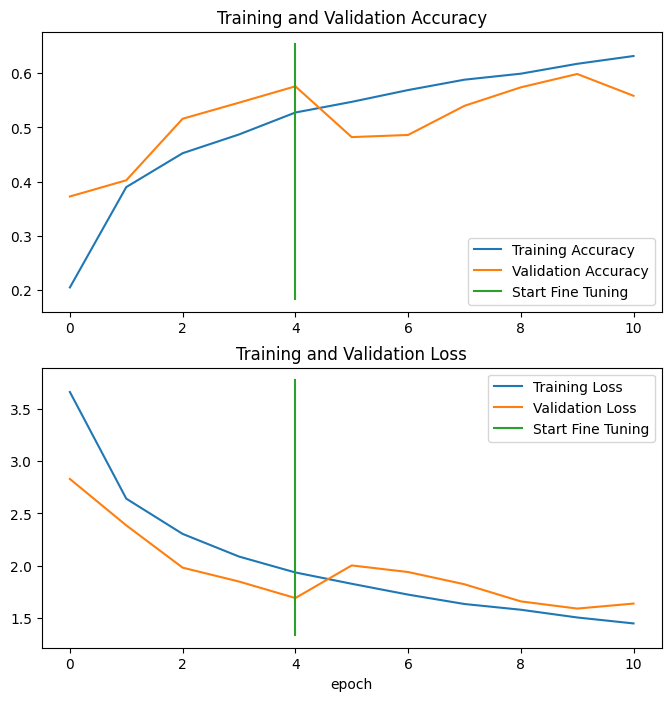

In [ ]:
compare_historys(exp_1_history, exp_2_history)

## Evaluating the performance of the big dog model across all different classes

In [ ]:
exp_1_pred_results.shape, exp_2_pred_results.shape

((25250, 101), (25250, 101))

In [ ]:
exp_1_pred_results[:10]

array([[7.1469821e-02, 4.9937950e-03, 2.0646834e-01, ..., 7.3031266e-04,
        3.3154979e-03, 6.0799576e-02],
       [9.3492550e-01, 8.4637513e-06, 1.7884056e-03, ..., 3.0727615e-03,
        5.0760450e-06, 8.1600829e-06],
       [5.7715081e-02, 5.7528280e-03, 3.7348871e-03, ..., 1.5452872e-03,
        5.4612500e-04, 4.5867488e-03],
       ...,
       [1.7920603e-01, 3.7526774e-05, 8.4345305e-04, ..., 5.1365793e-02,
        1.8117883e-03, 3.4308838e-04],
       [5.5957410e-02, 1.7464787e-03, 5.3703815e-02, ..., 1.5961484e-03,
        7.8946521e-04, 9.8277989e-04],
       [3.5944504e-01, 1.0035569e-04, 5.9530963e-03, ..., 2.7934367e-02,
        1.7722072e-04, 9.3840035e-03]], dtype=float32)

In [ ]:
exp_2_pred_results[:10]

array([[7.1469821e-02, 4.9937950e-03, 2.0646834e-01, ..., 7.3031266e-04,
        3.3154979e-03, 6.0799576e-02],
       [9.3492550e-01, 8.4637513e-06, 1.7884056e-03, ..., 3.0727615e-03,
        5.0760450e-06, 8.1600829e-06],
       [5.7715081e-02, 5.7528280e-03, 3.7348871e-03, ..., 1.5452872e-03,
        5.4612500e-04, 4.5867488e-03],
       ...,
       [1.7920603e-01, 3.7526774e-05, 8.4345305e-04, ..., 5.1365793e-02,
        1.8117883e-03, 3.4308838e-04],
       [5.5957410e-02, 1.7464787e-03, 5.3703815e-02, ..., 1.5961484e-03,
        7.8946521e-04, 9.8277989e-04],
       [3.5944504e-01, 1.0035569e-04, 5.9530963e-03, ..., 2.7934367e-02,
        1.7722072e-04, 9.3840035e-03]], dtype=float32)

In [ ]:
exp_1_pred_results[0], len(exp_1_pred_results[0])

(array([7.14698210e-02, 4.99379495e-03, 2.06468344e-01, 5.42922862e-06,
        1.69392679e-05, 8.73475146e-05, 4.33941046e-03, 6.29473361e-04,
        1.55537408e-02, 5.72951743e-03, 6.46998888e-05, 2.39249712e-04,
        9.35820118e-03, 2.97972056e-05, 1.45389829e-02, 4.09564283e-03,
        6.54298463e-04, 3.70829413e-03, 7.56436784e-04, 7.13561967e-05,
        1.47514744e-03, 1.67213351e-04, 1.78174139e-03, 6.84799685e-04,
        3.36171332e-04, 3.13308812e-03, 1.59917586e-03, 1.13253504e-04,
        4.51764055e-02, 6.12526527e-03, 3.26093104e-05, 1.33335416e-03,
        2.89814826e-03, 7.45326633e-06, 2.15070657e-02, 1.25446197e-04,
        1.80312828e-03, 3.90325766e-03, 2.76163965e-02, 8.34670136e-05,
        1.15785270e-03, 1.74973405e-03, 8.19289999e-04, 4.10882712e-05,
        6.89667941e-05, 1.30082655e-03, 2.12874892e-03, 3.79122124e-04,
        2.65595700e-05, 2.93417219e-02, 2.42318562e-03, 1.13580107e-04,
        1.45976856e-01, 2.88903899e-02, 3.25457768e-05, 1.149260

In [ ]:
exp_1_pred_classes = exp_1_pred_results.argmax(axis=1)
exp_2_pred_classes = exp_2_pred_results.argmax(axis=1)

exp_2_pred_classes[:5], exp_1_pred_classes[:5]

(array([ 2,  0, 80, 38,  8]), array([ 2,  0, 80, 38,  8]))

In [ ]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, exp_2_pred_classes)
sklearn_accuracy

0.5381782178217822

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=exp_2_pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, exp_2_pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.14      0.20       250
           1       0.34      0.72      0.46       250
           2       0.60      0.48      0.53       250
           3       0.75      0.48      0.58       250
           4       0.40      0.41      0.40       250
           5       0.31      0.36      0.34       250
           6       0.65      0.77      0.70       250
           7       0.77      0.75      0.76       250
           8       0.23      0.50      0.32       250
           9       0.34      0.61      0.44       250
          10       0.33      0.46      0.39       250
          11       0.77      0.42      0.54       250
          12       0.68      0.52      0.59       250
          13       0.38      0.55      0.45       250
          14       0.54      0.39      0.45       250
          15       0.29      0.41      0.34       250
          16       0.71      0.46      0.55       250
          17       0.41    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, exp_2_pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3804347826086957,
  'recall': 0.14,
  'f1-score': 0.20467836257309943,
  'support': 250.0},
 '1': {'precision': 0.3383177570093458,
  'recall': 0.724,
  'f1-score': 0.4611464968152866,
  'support': 250.0},
 '2': {'precision': 0.5960591133004927,
  'recall': 0.484,
  'f1-score': 0.5342163355408388,
  'support': 250.0},
 '3': {'precision': 0.7531645569620253,
  'recall': 0.476,
  'f1-score': 0.5833333333333334,
  'support': 250.0},
 '4': {'precision': 0.39615384615384613,
  'recall': 0.412,
  'f1-score': 0.40392156862745093,
  'support': 250.0},
 '5': {'precision': 0.3146853146853147,
  'recall': 0.36,
  'f1-score': 0.3358208955223881,
  'support': 250.0},
 '6': {'precision': 0.6454849498327759,
  'recall': 0.772,
  'f1-score': 0.703096539162113,
  'support': 250.0},
 '7': {'precision': 0.7695473251028807,
  'recall': 0.748,
  'f1-score': 0.7586206896551725,
  'support': 250.0},
 '8': {'precision': 0.2336448598130841,
  'recall': 0.5,
  'f1-score': 0.318471337579617

In [ ]:
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.20467836257309943,
 'baby_back_ribs': 0.4611464968152866,
 'baklava': 0.5342163355408388,
 'beef_carpaccio': 0.5833333333333334,
 'beef_tartare': 0.40392156862745093,
 'beet_salad': 0.3358208955223881,
 'beignets': 0.703096539162113,
 'bibimbap': 0.7586206896551725,
 'bread_pudding': 0.3184713375796178,
 'breakfast_burrito': 0.437410071942446,
 'bruschetta': 0.3852596314907873,
 'caesar_salad': 0.5402597402597403,
 'cannoli': 0.5876993166287017,
 'caprese_salad': 0.4509803921568628,
 'carrot_cake': 0.45265588914549654,
 'ceviche': 0.33943427620632277,
 'cheese_plate': 0.5547445255474452,
 'cheesecake': 0.386411889596603,
 'chicken_curry': 0.3765281173594132,
 'chicken_quesadilla': 0.5257985257985257,
 'chicken_wings': 0.6452762923351157,
 'chocolate_cake': 0.486140724946695,
 'chocolate_mousse': 0.3235955056179775,
 'churros': 0.7165532879818594,
 'clam_chowder': 0.702127659574468,
 'club_sandwich': 0.5891783567134269,
 'crab_cakes': 0.3283018867924528,
 'creme_brulee':

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33        edamame  0.958416
75            pho  0.832031
86        sashimi  0.830645
63       macarons  0.818391
45  frozen_yogurt  0.805556

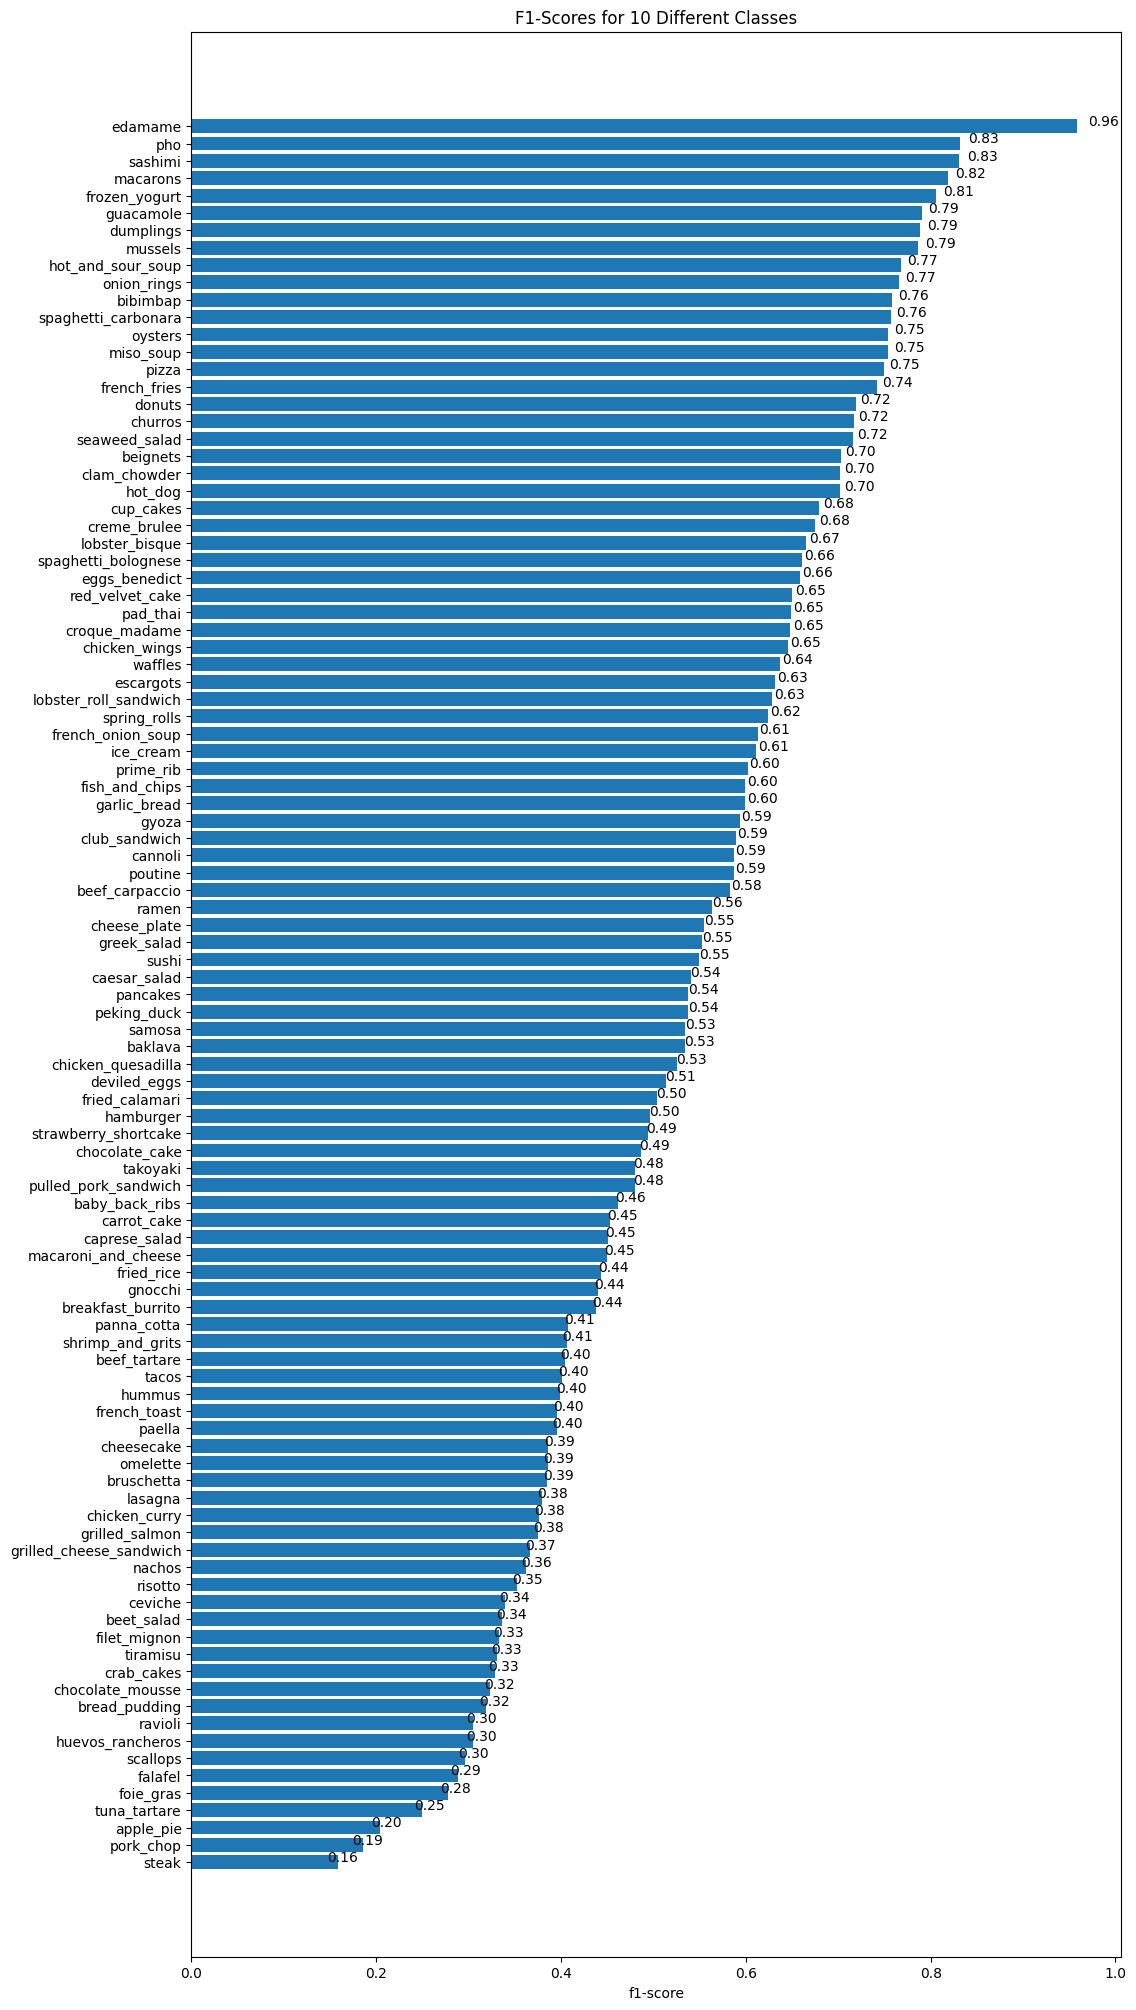

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Visualizing predictions on test images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


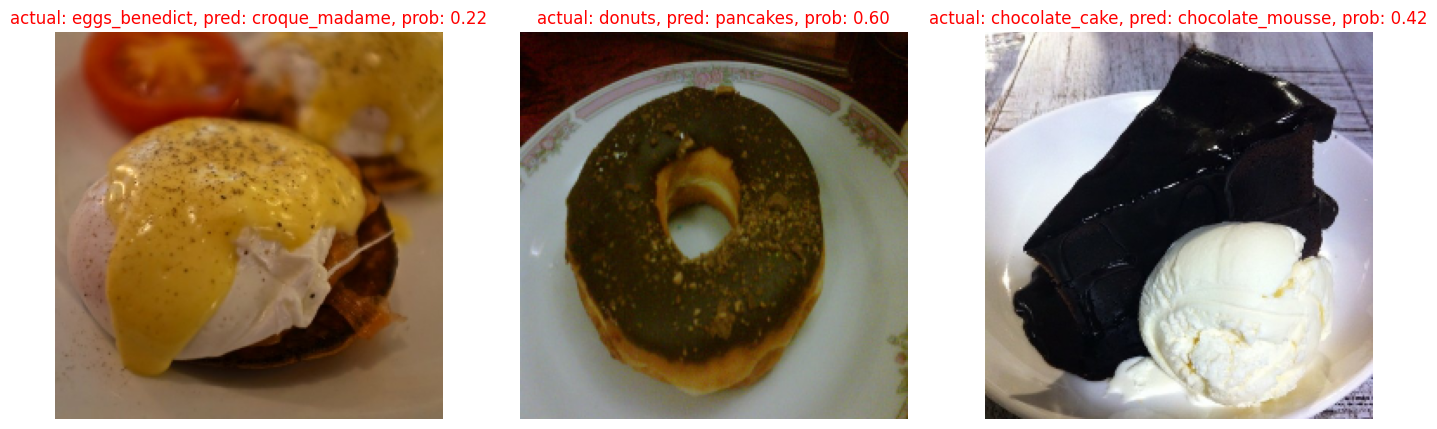

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(testing_data_dir + "/" + class_name))
  filepath = testing_data_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": exp_1_pred_classes,
                        "pred_conf": exp_2_pred_results.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in exp_1_pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname      y_pred_classname  
0   0.206468        apple_pie               baklava  
1   0.934925        apple_pie             apple_pie  
2   0.162036        apple_pie  pulled_pork_sandwich  
3   0.154059        apple_pie        fish_and_chips  
4   0.232130        apple_pie         bread_pudding

In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      38   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.206468        apple_pie               baklava         False  
1   0.934925        apple_pie             apple_pie          True  
2   0.162036        apple_pie  pulled_pork_sandwich         False  
3   0.154059        apple_pie        fish_and_chips         False  
4   0.232130        apple_pie         bread_pudding         False

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
22606  b'101_food_classes_10_percent/test/spaghetti_b...      90       1   
11097  b'101_food_classes_10_percent/test/fried_rice/...      44      70   
19521  b'101_food_classes_10_percent/test/poutine/132...      78      40   
15826  b'101_food_classes_10_percent/test/macarons/19...      63      29   
17816  b'101_food_classes_10_percent/test/paella/1762...      71      70   
21216  b'101_food_classes_10_percent/test/risotto/493...      84      70   
21913  b'101_food_classes_10_percent/test/scallops/34...      87       5   
18054  b'101_food_classes_10_percent/test/pancakes/18...      72       1   
14809  b'101_food_classes_10_percent/test/lasagna/215...      59      27   
10854  b'101_food_classes_10_percent/test/fried_calam...      43      68   
22     b'101_food_classes_10_percent/test/apple_pie/1...       0     100   
22511  b'101_food_classes_10_percent/test/spaghetti_b...      90      78   
5849   b'101_food_classes_10_percent/test/churros/254...      23      68   
10947  b'101_food_classes_10_percent/test/fried_calam...      43      68   
5652   b'101_food_classes_10_percent/test/chocolate_m...      22      98   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
22044  b'101_food_classes_10_percent/test/seaweed_sal...      88       5   

       pred_conf      y_true_classname y_pred_classname  pred_correct  
23631   0.993921  strawberry_shortcake  red_velvet_cake         False  
10847   0.990770        fried_calamari      onion_rings         False  
23797   0.990617                 sushi          sashimi         False  
22606   0.985739   spaghetti_bolognese   baby_back_ribs         False  
11097   0.985185            fried_rice         pad_thai         False  
19521   0.984800               poutine     french_fries         False  
15826   0.984714              macarons        cup_cakes         False  
17816   0.980841                paella         pad_thai         False  
21216   0.979897               risotto         pad_thai         False  
21913   0.979675              scallops       beet_salad         False  
18054   0.979589              pancakes   baby_back_ribs         False  
14809   0.974084               lasagna     creme_brulee         False  
10854   0.973970        fried_calamari      onion_rings         False  
22      0.973723             apple_pie          waffles         False  
22511   0.970964   spaghetti_bolognese          poutine         False  
5849    0.970467               churros      onion_rings         False  
10947   0.969586        fried_calamari      onion_rings         False  
5652    0.969016      chocolate_mousse         tiramisu         False  
18001   0.968433              pancakes         omelette         False  
22044   0.968009         seaweed_salad       beet_salad         False

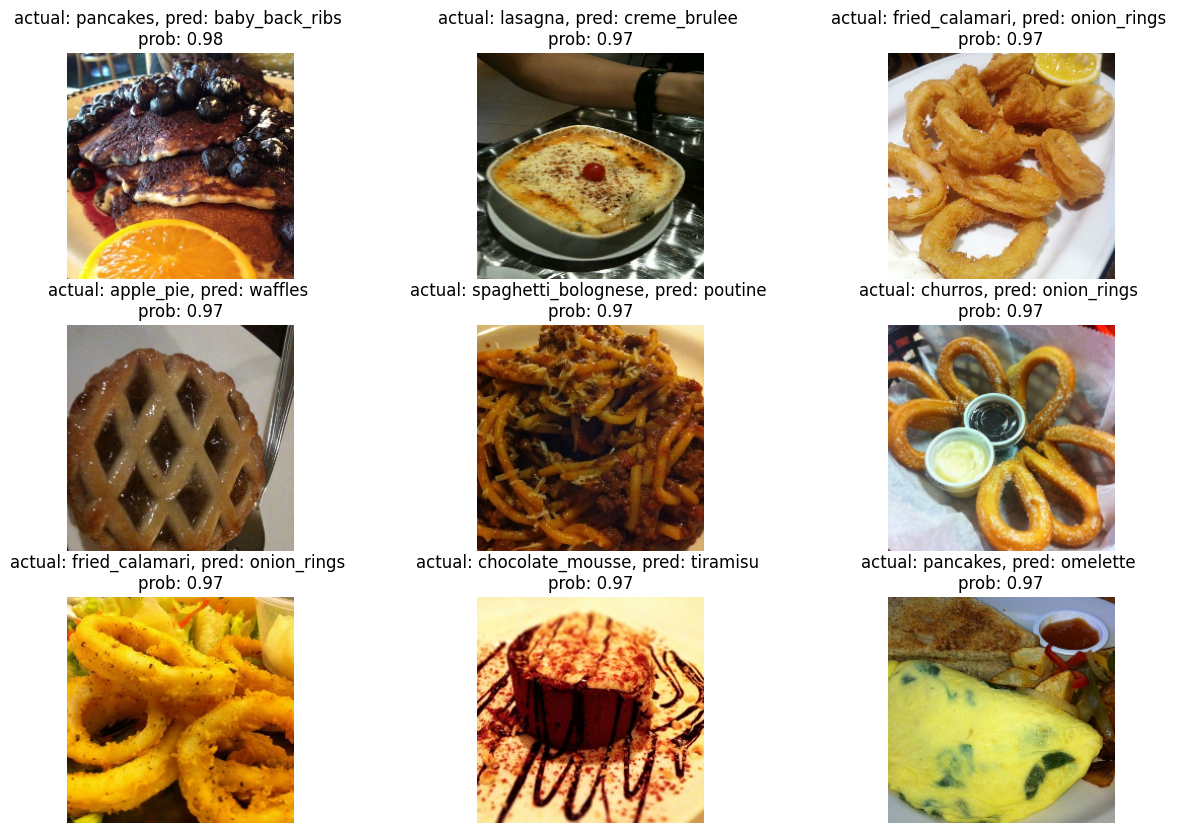

In [ ]:
#  5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

## Test out the big dog model on test images as well as custom images of food

In [ ]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2024-08-10 11:32:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.20MB/s    in 1.7s    

2024-08-10 11:32:29 (7.20 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


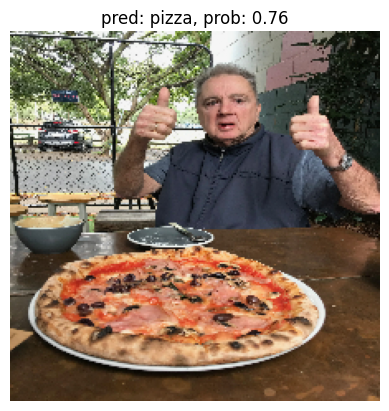

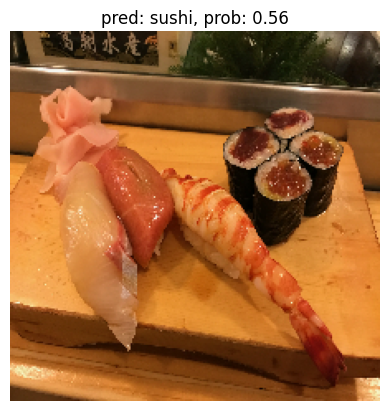

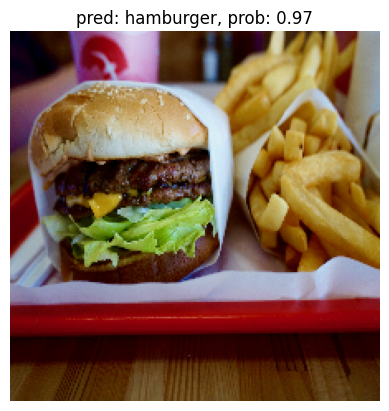

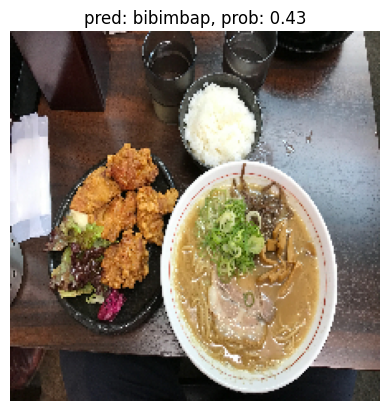

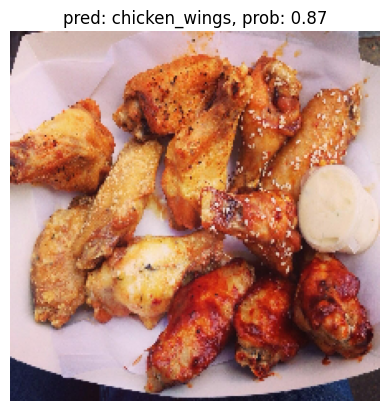

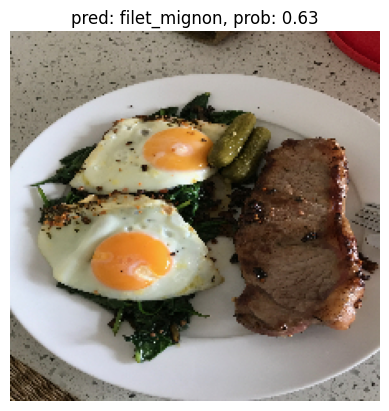

In [ ]:

# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)